<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. DNN Basis**
# Section 5. 신경망의 순전파

### _Objective_
1. **Feedforward Network**: Feedforward Network가 무엇인지 알아봅니다.<br>
2. **Feedforward with Keras**: Keras를 사용해 feedforward 모델을 모델링해봅니다.<br>
3. **Feedforward with Numpy**: Numpy를 사용해 간단하게 순전파 수식을 구현해 봅니다.<br>

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# \[ 1. Feedforward Network \]

순전파(Feedforward)란 신경망에서 입력층부터 출력층까지 각 층을 거쳐가며 신호가 타고넘어가는 일련의 과정을 뜻합니다. 입력층부터 출력층까지 앞에서 뒤로 신호가 타고 넘어가 '순전파'라는 이름이 붙었습니다. Keras와 Numpy를 이용해 구현해보겠습니다.

## 1. 유닛 단위의 순전파 연산

순전파에서 유닛의 연산은 기본적으로 앞서 다룬 로지스틱 회귀 모델과 매우 닮아 있습니다. 로지스틱 회귀 모델은 아래의 두 단계로 이루어져 있습니다.<br>

1. 로짓(z)를 계산하는 부분 : <br>
$
z = w_0 + w_1x_1 + w_2x_2 + w_3x_3\\
$

2. 활성화 함수($\sigma$)를 거치는 부분 : <br>
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

순전파에서 유닛의 연산도 로지스틱 회귀와 동일하게 두단계로 이루어집니다.

1. 로짓(z)를 계산하는 왼쪽 부분
2. 활성화함수($\sigma$)를 거치는 오른쪽 부분

![](https://i.imgur.com/26G8oSL.png)



## 2. 층 단위의 순전파 연산

입력층과 은닉층(유닛 수, 활성화 함수 등)을 설정하는 방법을 살펴보았습니다. 그럼 이제 아래와 같이 생긴 2층 신경망을 처음부터 끝까지 구현하는 코드를 살펴봅시다.  

<img src="https://i.imgur.com/T9jkFuv.png" width="600" height="450"/><br>

$$
z1 = X\cdot W1 + b1 \\
a1 = \sigma(z1) \\
z2 = a1 \cdot W2 + b2 \\
\hat y = \sigma(z2)
$$

# \[ 2. Keras로 Feedforward Network 구현하기 \]

### 예제 데이터 ) 암 환자 데이터 셋

나이와 종양크기를 바탕으로 암 환자의 종양이 양성인지 음성인지를 분류하는 데이터셋입니다.

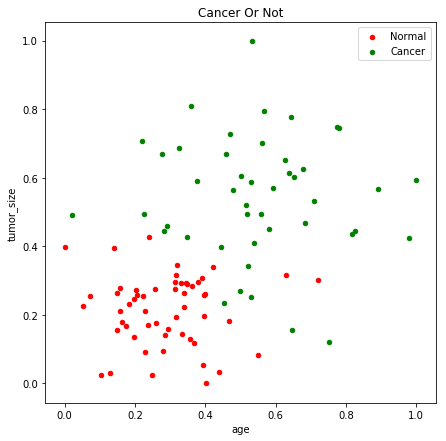

In [2]:
if not os.path.exists("./cancer_dataset.csv"):
    !wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
cancer_df = pd.read_csv('cancer_dataset.csv')

X = cancer_df[['age','tumor_size']]
y = cancer_df["label"]

X = (X - X.min()) / (X.max() - X.min())

### 데이터 시각화
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='red')
# 1: 암환자
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

### (1) Input 설정하기

신경망의 Input Layer에 넣을 입력 신호를 설정하기 위해 keras에서는 `keras.layers.Input` API를 지원합니다.

In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

위 예제 데이터에서 입력 데이터 `X`는 나이(age)와 종양의 크기(tumor_size)로 구성됩니다. X가 2 가지이므로, 입력층의 shape은 `(2,)`으로 설정하여 `Input(shape=(2,), name='x')`로 입력층을 생성합니다.

In [4]:
K.clear_session() # Session을 초기화, 이전에 만들어놓았던 딥러닝 모델들을 삭제
inputs = Input(shape=(2,), name='x') # 입력의 shape 지정
display(inputs)

<tf.Tensor 'x:0' shape=(None, 2) dtype=float32>

그런데 `display(inputs)`로 입력층의 내용을 출력해보면 `shape=(None, 2)`라고 확인됩니다. 여기서 None은 무슨 의미일까요? 

이전 Section에서 말했듯이 keras에서는 첫번째 축이 Batch 축으로 세팅되어 있으며, 따로 설정해 주지 않으면 None을 반환합니다. 위 예제에서 Batch 축을 따로 세팅하지 않았으므로, 입력층의 shape이 `(None,2)`가 됨을 볼 수 있습니다. 

데이터를 하나로 묶은 입력 데이터를 **배치(Batch)**라고 하는데, None은 입력한 데이터 전체를 하나로 묶어 처리한다는 뜻입니다. 위 예제에서는 batch를 따로 설정하지 않았기 때문에 100명 분의 데이터가 전부 한 번에 처리가 될 것입니다. batch를 10, 50 등으로 설정하면 10명, 50명 분의 데이터가 하나의 batch로 묶여서 돌아가게 됩니다.

배치 처리를 수행함으로써 컴퓨터는 큰 배열로 이루어진 계산을 하게 되는데, 컴퓨터에서는 큰 배열을 한꺼번에 계산하는 것이 분할된 작은 배열을 여러 번 계산하는 것보다 빠릅니다. 덕분에 배치 처리를 하게 되면, 환자 한 명의 정보를 처리하는 것보다, 환자 한 명당 처리 시간이 대폭 줄어드는 이득을 얻을 수 있습니다.

### (2) 가중치(weight)와 편향(bias) 생성하기

입력층이 설정되었습니다. 앞서 예로 든 것처럼 10개 유닛으로 구성된 1번 층을 만들어 2층 신경망을 구성하게 되면, 학습해야 하는 가중치와 편향에는 ($w_1$,$b_1$,$w_2$,$b_2$) 등이 있습니다. keras에서는 가중치를 계산하며 층을 쌓을 때는 `keras.layers.Dense` API를 이용합니다.

In [5]:
from tensorflow.keras.layers import Dense
dense1 = Dense(units=10)(inputs)
dense1

<tf.Tensor 'dense/Identity:0' shape=(None, 10) dtype=float32>

In [6]:
# input이 inputs, output이 dense1인 model 생성
# 해당 코드에 대해서는 아래에서 한번 더 다룰 것입니다.
from tensorflow.keras.models import Model
model = Model(inputs, dense1)

dense1의 가중치 $w_1$와 편향$b_1$가 어떤 형태인지 확인해봅시다. 

In [7]:
W, b = model.get_weights()
print(f"W >>> shape  : {W.shape}")
display(W)

print(f"b >>> shape  : {b.shape}")
display(b)

W >>> shape  : (2, 10)


array([[ 0.43970996, -0.53285754, -0.23773098,  0.68216616,  0.3591711 ,
         0.45950097,  0.44768566,  0.3113479 ,  0.08351058,  0.6016938 ],
       [-0.32946292,  0.09483093,  0.5202959 , -0.311577  ,  0.2579288 ,
        -0.08358413,  0.69020313,  0.37579113,  0.24077785,  0.21935833]],
      dtype=float32)

b >>> shape  : (10,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

위 내용을 보면, 입력 데이터의 크기에 맞게 자동으로 가중치(`W`와 `b`)가 생성되어 있음을 알 수 있습니다. 입력 데이터에 피쳐가 2가지이고 유닛은 10개이므로, $w_1$는 (2, 10) 형태를 가지게 되었으며, $b_1$은 (10,)의 형태를 가지게 되었습니다. 

신경망 학습에서 처음 가중치를 생성할 때, 아무 값이나 넣어 만들면 될까요? 그렇지 않습니다. 가중치의 초기 구성은 신경망을 설계할 때 고려해야하는 중요 요소 중 하나입니다. 가중치의 초기 구성, 즉 가중치의 초기화에 대해서는 Appendix에서 다루겠습니다.

10개의 유닛으로 구성된 1번째 층이 생성되었으니, 입력신호를 `dense1`층에 통과시켜 보겠습니다.

In [8]:
from tensorflow.keras.layers import Dense
dense1 = Dense(units=10)(inputs)
dense1_out = dense1

이렇게 1번째 층을 통과하여 얻어진`dense1_out1`은 활성화 함수의 입력값이 될 것입니다. 

### (3) 활성화 함수 적용하기

활성화 함수로 딥러닝에서 가장 많이 쓰이는 `relu`함수를 이용해 입력 신호의 총합을 출력 신호로 변환하겠습니다. ReLU 함수란 아래와 같습니다.

$$
RELU(x) = \begin{cases} 
x && \mbox{if x } \ge 0 \\
0 && \mbox{if x } < 0 \\
\end{cases}
$$


0보다 작은 값을 받으면 0을 반환하고, 0보다 크거나 같은 값을 받으면 입력 값을 그대로 반환하는 형태입니다.

앞서 `dense1`을 통과하여 얻은 `dense1_out`을 `relu`에 입력하면 0 또는`x`로 변환된 `relu_out`을 얻을 수 있습니다.

In [9]:
from tensorflow.keras.activations import relu, sigmoid
relu1_out = relu(dense1_out)
relu1_out

<tf.Tensor 'Relu:0' shape=(None, 10) dtype=float32>

실제 신경망을 구성할 때는 층을 구성할 때 `activation`이라는 인자를 이용해 활성화 함수를 설정할 수 있습니다. 가령 1번째 층에서 유닛을 10개로 설정하고, 활성화 함수는 `relu`로 설정하려면 아래와 같이 설정하면 됩니다.

In [10]:
dense1 = Dense(10,activation='relu', name='hidden')
dense1_output = dense1(inputs)

### (4) 2층 신경망 구현하기

입력층과 은닉층(유닛 수, 활성화 함수 등)을 설정하는 방법을 살펴보았습니다. 그럼 이제 아래와 같이 생긴 2층 신경망을 처음부터 끝까지 구현하는 코드를 살펴봅시다.  

<img src="https://i.imgur.com/T9jkFuv.png" width="600" height="450"/><br>

$$
z1 = X\cdot W1 + b1 \\
a1 = \sigma(z1) \\
z2 = a1 \cdot W2 + b2 \\
\hat y = \sigma(z2)
$$

keras에서는 keras의 함수형 API를 사용할 때, input과 output을 지정해주면 신경망의 흐름대로 모델을 생성하는 `keras.models.Model` API를 지원합니다. `Model`에 입력층과 출력층을 인자로 입력하면 신경망 모델이 생성됩니다.

In [11]:
from tensorflow.keras.models import Model

K.clear_session()
# 신경망 구현
inputs = Input(2,name='x')

dense1 = Dense(10,activation='relu', name='hidden')
dense1_output = dense1(inputs)

dense2 = Dense(1,activation='sigmoid', name='output')
output = dense2(dense1_output)

# 신경망 모델 생성
model = Model(inputs, output, name='train')

### (5) 신경망에 대한 정보 확인하기

keras에서는 `summary()`함수를 활용해 현재 생성된 모델에 대한 정보를 확인할 수 있습니다.

In [12]:
model.summary()

Model: "train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 2)]               0         
_________________________________________________________________
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### (6) 모델 사용하기

keras에서는 `model.predict(input_sample)`를 통해 입력값(input_sample)`X`가 model을 통과했을 때의 예측값(ouput prediction)을 얻을 수 있습니다. 여기서 얻은 예측값은 아직 최선의 가중치를 찾지 않은 초기 가중치 값을 통해 얻은 값이므로 오차율은 높을 수 있습니다.

In [13]:
model.predict(X)

array([[0.4985342 ],
       [0.48044991],
       [0.49872822],
       [0.49851704],
       [0.49812895],
       [0.4533424 ],
       [0.4995576 ],
       [0.49843565],
       [0.49584115],
       [0.48811677],
       [0.49958247],
       [0.49473652],
       [0.49823138],
       [0.48948526],
       [0.48803017],
       [0.4364057 ],
       [0.49932826],
       [0.4980484 ],
       [0.48945147],
       [0.5001008 ],
       [0.49867007],
       [0.49964327],
       [0.4955422 ],
       [0.4886012 ],
       [0.50067586],
       [0.45532683],
       [0.49815086],
       [0.49733317],
       [0.4891248 ],
       [0.4858804 ],
       [0.4993651 ],
       [0.5004331 ],
       [0.49956965],
       [0.500545  ],
       [0.50018144],
       [0.4522363 ],
       [0.49495986],
       [0.49720272],
       [0.49791855],
       [0.48151195],
       [0.46512097],
       [0.49982205],
       [0.49716514],
       [0.49562556],
       [0.49080434],
       [0.50081784],
       [0.49602053],
       [0.492

# \[ 3. Numpy를 이용해 순전파 과정 진행하기 \]

Keras로 구현한 순전파 네트워크가 잘 돌아가는지, Keras에서 얻은 가중치 값을 가져와 Numpy 코드로 직접 수식을 구현하여 단계별로 얻어지는 값을 확인하고, 예측 결과 값을 비교해보겠습니다. 앞서 사용한 암환자 데이터셋을 이용해보겠습니다.

### (1) 가중치 가져오기

keras에서는 `model.get_layer('layer_name').get_weights()`을 통해 모델 내 원하는 층의 가중치 값을 가져올 수 있습니다. 이는 class 또는 instance의 이동으로 다른 구조에서 가중치 값을 간단하게 공유할 수 있다는 점은 keras의 장점 중 하나입니다.

In [14]:
W1, B1 = model.get_layer('hidden').get_weights()
W2, B2 = model.get_layer('output').get_weights()

np.set_printoptions(3)
print("W1 >>>")
display(W1)
print("B1 >>>")
display(B1)
print("W2 >>>")
display(W2)
print("B2 >>>")
display(B2)

W1 >>>


array([[ 0.466,  0.304,  0.048, -0.444,  0.678, -0.357, -0.33 ,  0.513,
         0.253, -0.303],
       [-0.678, -0.022,  0.127, -0.261,  0.672,  0.511,  0.205,  0.062,
        -0.021, -0.292]], dtype=float32)

B1 >>>


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

W2 >>>


array([[-0.682],
       [-0.604],
       [ 0.705],
       [-0.055],
       [ 0.144],
       [-0.525],
       [-0.113],
       [-0.086],
       [-0.129],
       [-0.175]], dtype=float32)

B2 >>>


array([0.], dtype=float32)

### (2) 순전파 수식 구현
첫번째 층을 통과하는 과정을 살펴봅시다.

<img src="https://i.imgur.com/o1SgBJZ.png" width="600" height="450"/><br>

위에 도식에서 입력 데이터 X가 가중치와 곱해진 결과값을 얻는 과정을 수식으로 나타내면 다음과 같습니다.

$
Z_1 = X \cdot W_1 + B_1
$

이를 numpy 식으로 구현하면 아래와 같이 됩니다. 

In [15]:
X = cancer_df[['age','tumor_size']].values
hidden1 = np.dot(X, W1) + B1
# hidden1

### (3) 활성화 함수 적용
이렇게 입력값에 가중치를 곱해 얻은 $Z_1$, 즉`hidden1`에 `relu`활성화 함수를 적용해 보겠습니다.

<img src="https://i.imgur.com/QVfBn7d.png" width="600" height="450"/><br>

$a_1 = RELU(z_1)$


이를 numpy 식으로 구현하면 아래와 같이 됩니다. 

In [16]:
hidden1_np_output = np.maximum(hidden1,0)
# hidden1_np_output

### (4) 순전파 수식 구현
두번째 layer를 통과하는 과정입니다.

<img src="https://i.imgur.com/WKOjOg6.png" width="600" height="450"/><br>

첫 번째 층을 통과한 결과 값을 입력 값으로 받아 가중치 $W_2$와 곱하고, 편향 $b_2$를 더합니다. 

In [17]:
output_z = np.dot(hidden1_np_output, W2) + B2
# output_z

### (5) 활성화 함수 적용
최종적으로 두 번째 층의 결과값을 내기 위해 `output_z`에 `sigmoid`활성화 함수를 적용해 보겠습니다.
<img src="https://i.imgur.com/9AceY76.png" width="600" height="450"/><br>

In [18]:
np_output = 1/(1+np.exp(-output_z))
np_output

array([[0.477],
       [0.47 ],
       [0.472],
       [0.474],
       [0.472],
       [0.203],
       [0.486],
       [0.468],
       [0.451],
       [0.496],
       [0.485],
       [0.431],
       [0.467],
       [0.377],
       [0.381],
       [0.116],
       [0.478],
       [0.46 ],
       [0.476],
       [0.488],
       [0.477],
       [0.486],
       [0.436],
       [0.372],
       [0.499],
       [0.193],
       [0.5  ],
       [0.464],
       [0.368],
       [0.518],
       [0.48 ],
       [0.495],
       [0.488],
       [0.491],
       [0.497],
       [0.186],
       [0.433],
       [0.456],
       [0.459],
       [0.412],
       [0.265],
       [0.497],
       [0.462],
       [0.439],
       [0.392],
       [0.49 ],
       [0.446],
       [0.489],
       [0.453],
       [0.39 ],
       [0.488],
       [0.499],
       [0.349],
       [0.491],
       [0.489],
       [0.295],
       [0.399],
       [0.508],
       [0.457],
       [0.47 ],
       [0.341],
       [0.205],
       [

### (6) keras 결과와 비교하기

numpy에서 제공하는 testing 모듈을 통해 keras와 numpy를 이용해 만든 각각의 결과를 비교해보도록 하겠습니다. 아래 코드를 동작했을 때 아무 문제없이 작동하면 두 결과가 거의 일치하는 것이고, 그렇지 않다면 오류 메시지를 반환할 것입니다.

In [19]:
keras_output = model.predict(cancer_df[['age','tumor_size']])
np.testing.assert_array_almost_equal(np_output, keras_output)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/09/16


---